# Butterfly Images Multilabel Classification Problem

Dependencies import

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SparseCategoricalAccuracy, Precision, Recall
from tensorflow.keras.models import load_model
import seaborn as sns
import math
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from collections import Counter

Data load and getting information from the dataset.

In [38]:
# Load the data
folder_path = "./leedsbutterfly/images"

# Read all filenames in the folder
filenames = os.listdir(folder_path)

# Extract categories from the filenames
categories = {}
for filename in filenames:
    imagename, _ = os.path.splitext(filename)
    if imagename[1:3].isdigit(): 
        # Extract the category
        category = int(imagename[1:3])  
        categories[filename] = category

# Preprocessing images
image_size = (128, 128)  
images = []
original_labels = []
for filename in categories.keys(): 
    image_path = os.path.join(folder_path, filename)
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    images.append(img_array)
    
    # Set original_labels based on categories
    original_labels.append(categories[filename])


print(f"There are total {len(images)} images in this dataset.")


There are total 832 images in this dataset.


### There are only 832 images in the whole dataset. That is not enough to train a proper model therefore data augmentation is necessary.

In [39]:
# Implement the data augmentation generator again for sanity check
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Check augmented images and labels
augmented_images = []
augmented_labels = []
for img_array, label in zip(images, original_labels):
    img_array = np.expand_dims(img_array, axis=0)
    augmented_imgs_gen = datagen.flow(img_array, batch_size=1)
    for _ in range(4):
        augmented_img = next(augmented_imgs_gen)[0].astype(np.float32)
        augmented_images.append(augmented_img)
        augmented_labels.append(label)

# Combine original and augmented images
all_images = images + augmented_images
all_labels = original_labels + augmented_labels

# Convert to numpy array and normalize
all_images_array = np.array(all_images)
all_images_normalized = all_images_array.astype('float32') / 255.0

# Check if images are normalized correctly
print(f"Min pixel value after normalization: {all_images_normalized.min()}, Max pixel value after normalization: {all_images_normalized.max()}")

Min pixel value after normalization: 0.0, Max pixel value after normalization: 1.0


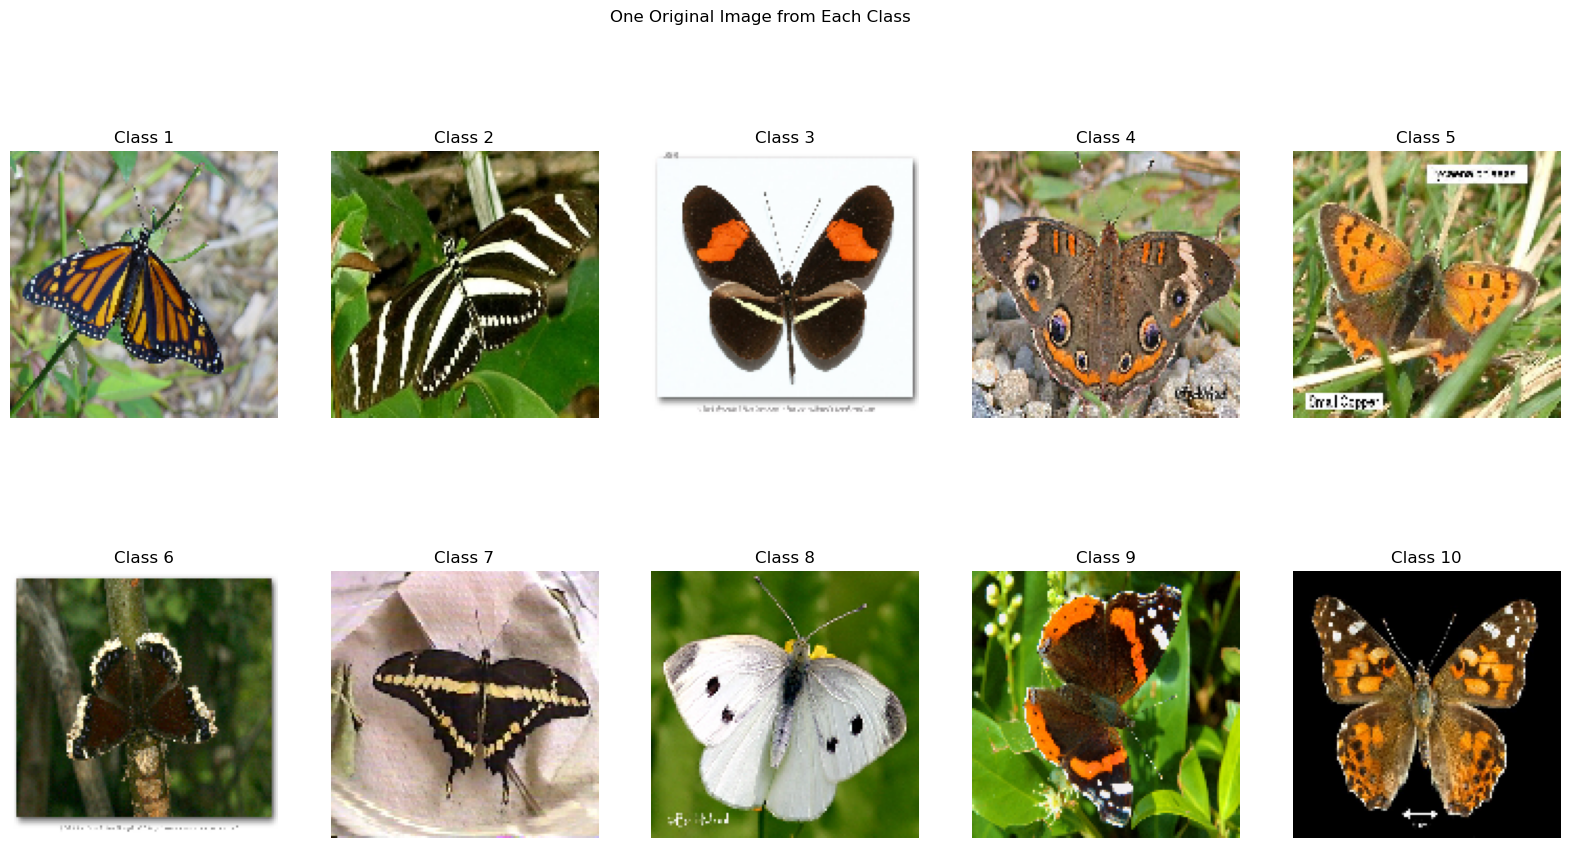

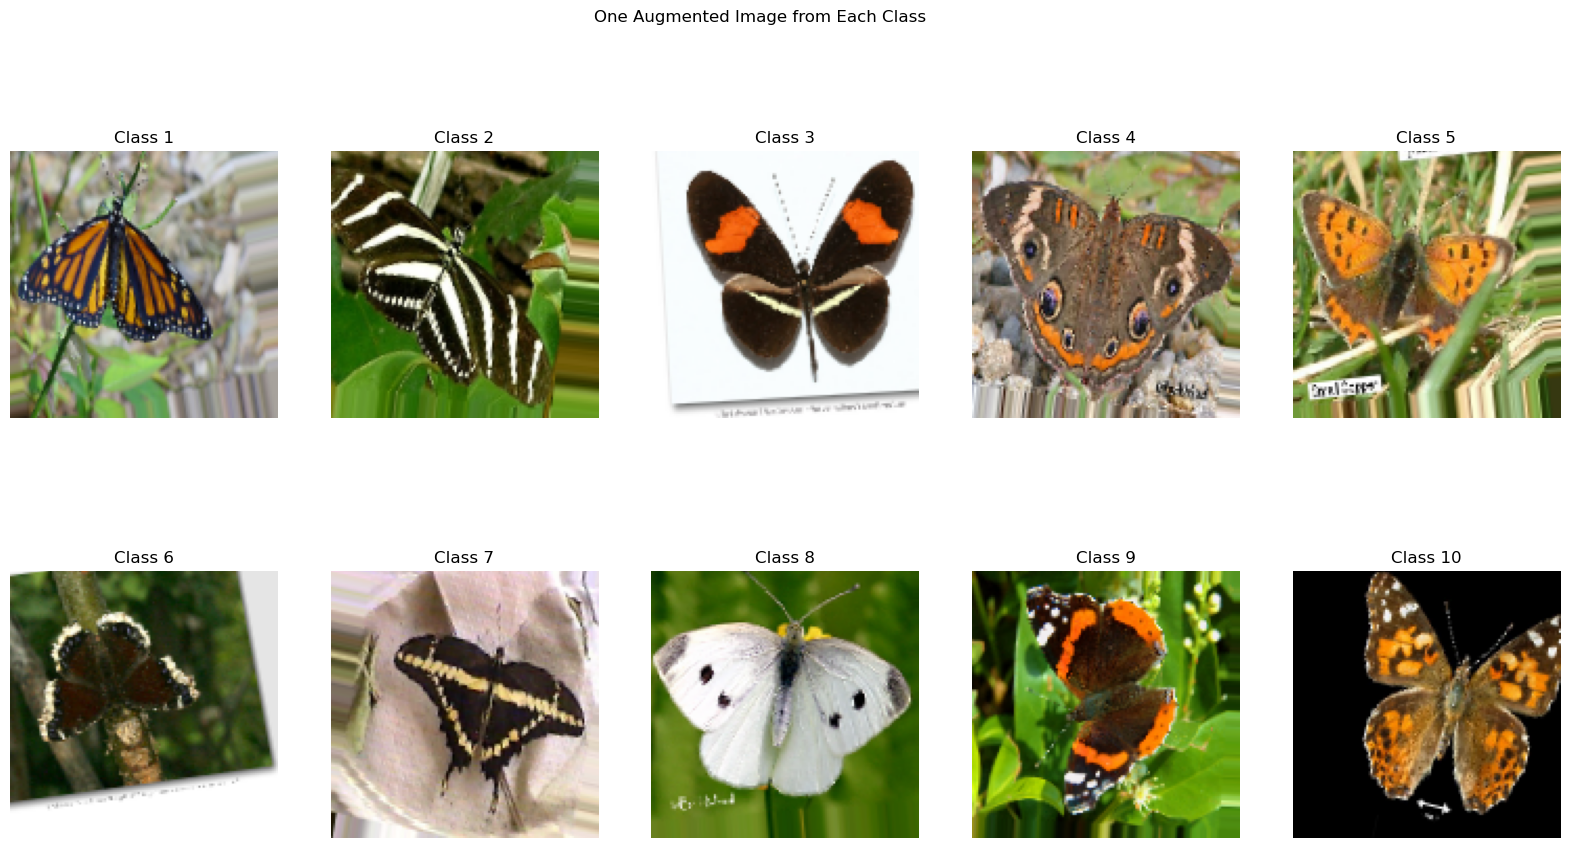

In [40]:
# Identify original images from each class
class_images = {}
for img_array, label in zip(images, original_labels):
    if label not in class_images:
        class_images[label] = img_array

# Sort the classes in ascending order
sorted_class_labels = sorted(class_images.keys())

# Plot one original image from each class
plt.figure(figsize=(20, 10))
for i, label in enumerate(sorted_class_labels, 1):
    img_array = class_images[label]
    plt.subplot(2, 5, i)
    plt.imshow(img_array.astype('uint8'))
    plt.title(f"Class {label}")
    plt.axis('off')
plt.suptitle('One Original Image from Each Class')
plt.show()

# Identify augmented images from each class
augmented_class_images = {label: [] for label in sorted_class_labels}
for img_array, label in zip(augmented_images, augmented_labels):
    if len(augmented_class_images[label]) < 1:
        augmented_class_images[label].append(img_array)

# Plot 1 augmented image from each class 
plt.figure(figsize=(20, 10))
for i, label in enumerate(sorted_class_labels):
    img_arrays = augmented_class_images[label]
    img_array = img_arrays[0] 
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_array.astype('uint8'))
    plt.title(f"Class {label}")
    plt.axis('off')
plt.suptitle('One Augmented Image from Each Class')
plt.show()


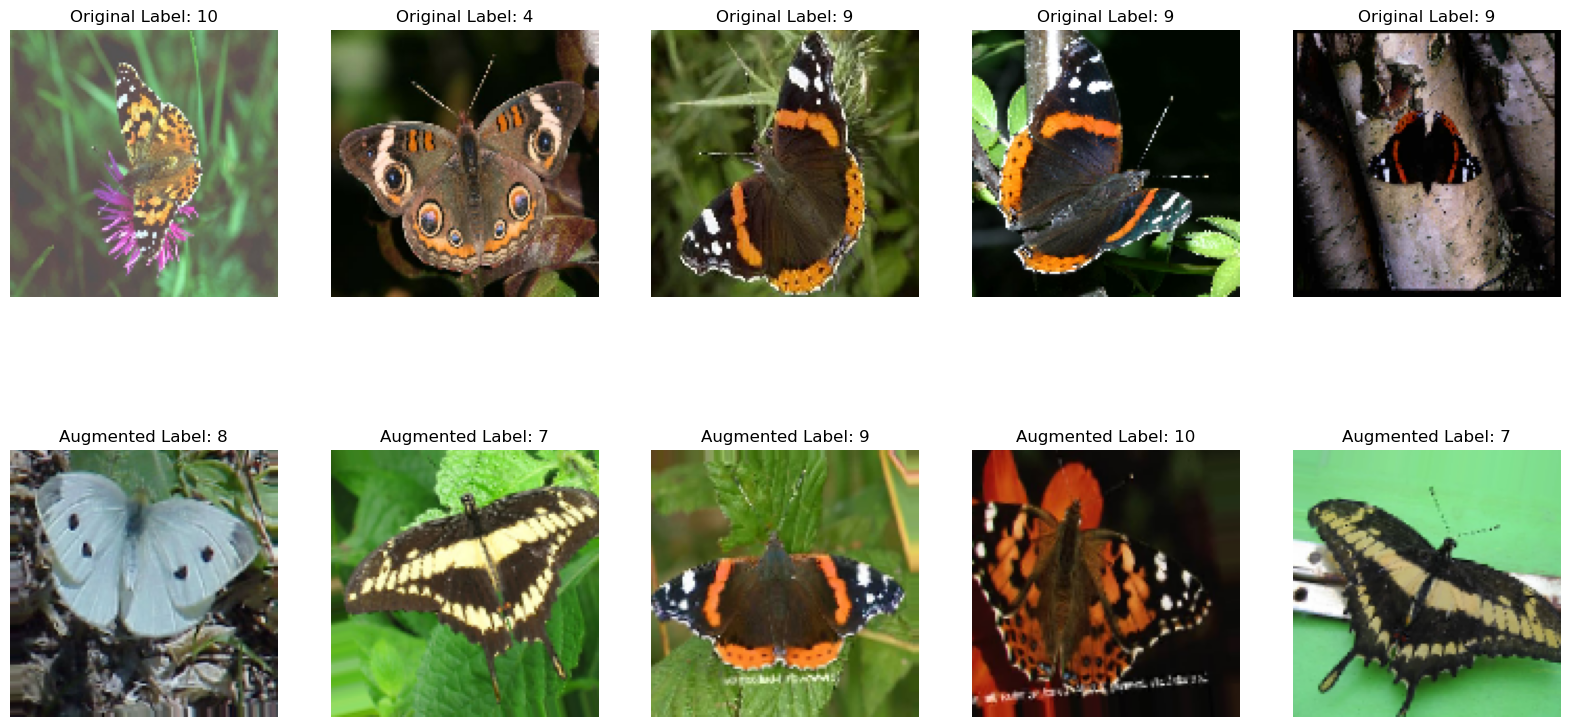

In [41]:
def plot_random_images(original_images, augmented_images, original_labels, augmented_labels, num_images=5):
    """
    Plots random original and augmented images with their labels.
    
    Parameters:
    - original_images: list or array of original images
    - augmented_images: list or array of augmented images
    - original_labels: list of original labels
    - augmented_labels: list of augmented labels
    - num_images: number of images to plot (default is 5)
    """
    
    # Plot random original images
    plt.figure(figsize=(20, 10))
    random_indices = random.sample(range(len(original_images)), num_images)
    for i, idx in enumerate(random_indices):
        plt.subplot(2, num_images, i+1)
        plt.imshow(original_images[idx].astype('uint8'))
        plt.title(f"Original Label: {original_labels[idx]}")
        plt.axis('off')
    
    # Plot random augmented images
    random_indices = random.sample(range(len(augmented_images)), num_images)
    for i, idx in enumerate(random_indices):
        plt.subplot(2, num_images, num_images+i+1)
        plt.imshow(augmented_images[idx].astype('uint8'))
        plt.title(f"Augmented Label: {augmented_labels[idx]}")
        plt.axis('off')
    
    plt.show()

plot_random_images(images, augmented_images, original_labels, augmented_labels, num_images=5)

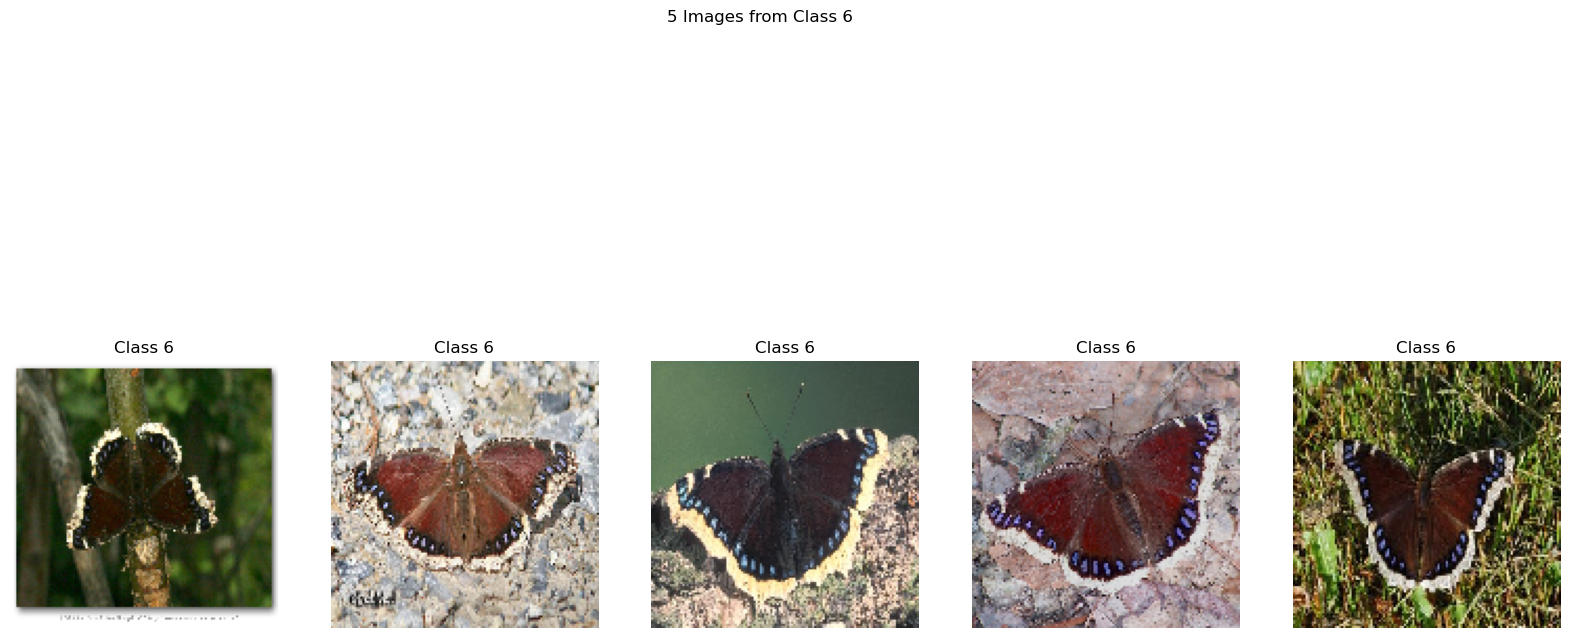

In [42]:
def plot_first_class_images(images, labels, num_images=5):
    """
    Plots a specified number of images from the first class in the dataset.
    
    Parameters:
    - images: list or array of images
    - labels: list of labels
    - num_images: number of images to plot (default is 5)
    """
    
    first_class_label = sorted(set(labels))[5]  # Get the first class label
    first_class_images = [img for img, label in zip(images, labels) if label == first_class_label]

    # Ensure we don't try to plot more images than we have
    num_images = min(num_images, len(first_class_images))
    
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(first_class_images[i].astype('uint8'))
        plt.title(f"Class {first_class_label}")
        plt.axis('off')
    
    plt.suptitle(f'{num_images} Images from Class {first_class_label}')
    plt.show()

# Call the function to plot 5 images from the first class
plot_first_class_images(images, original_labels, num_images=5)


## Splitting data for training.

Since there are 10 classes in labels but the arrays start numeration from zero, the substraction of 1 is required to prove a correct matching. 

In [43]:
# Split the data into training, validation, and test sets
train_mixed_images_normalized, val_mixed_images_normalized, train_mixed_labels, val_mixed_labels = train_test_split(
    all_images_normalized, all_labels, test_size=0.2, random_state=42)

val_mixed_images_normalized, test_mixed_images_normalized, val_mixed_labels, test_mixed_labels = train_test_split(
    val_mixed_images_normalized, val_mixed_labels, test_size=0.5, random_state=42)

# Convert labels to numpy arrays anc correct labels
train_mixed_labels = np.array(train_mixed_labels) - 1
val_mixed_labels = np.array(val_mixed_labels) - 1
test_mixed_labels = np.array(test_mixed_labels) - 1

# Model training

Firstly a simple model was created to see what would be the final accuracy. 

In [44]:
# Callbacks for improved training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [45]:
# Define a model with data augmentation
augmented_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model with a lower initial learning rate
augmented_model.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

augmented_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                      

In [46]:
# Train the model 
history_augmented = augmented_model.fit(train_mixed_images_normalized, train_mixed_labels,
                                        epochs=30,  
                                        validation_data=(val_mixed_images_normalized, val_mixed_labels),
                                        callbacks=[early_stopping, reduce_lr])  

Epoch 1/30
104/104 [==============================] - 39s 366ms/step - loss: 1.2785 - accuracy: 0.5487 - val_loss: 2.0115 - val_accuracy: 0.5433 - lr: 1.0000e-04
Epoch 2/30
104/104 [==============================] - 37s 351ms/step - loss: 0.5574 - accuracy: 0.8131 - val_loss: 1.6403 - val_accuracy: 0.6971 - lr: 1.0000e-04
Epoch 3/30
104/104 [==============================] - 30s 285ms/step - loss: 0.3052 - accuracy: 0.8990 - val_loss: 1.2726 - val_accuracy: 0.6370 - lr: 1.0000e-04
Epoch 4/30
104/104 [==============================] - 30s 285ms/step - loss: 0.1458 - accuracy: 0.9624 - val_loss: 0.8251 - val_accuracy: 0.7620 - lr: 1.0000e-04
Epoch 5/30
104/104 [==============================] - 30s 284ms/step - loss: 0.0640 - accuracy: 0.9922 - val_loss: 0.5572 - val_accuracy: 0.8173 - lr: 1.0000e-04
Epoch 6/30
104/104 [==============================] - 29s 282ms/step - loss: 0.0290 - accuracy: 0.9988 - val_loss: 0.4850 - val_accuracy: 0.8534 - lr: 1.0000e-04
Epoch 7/30
104/104 [========

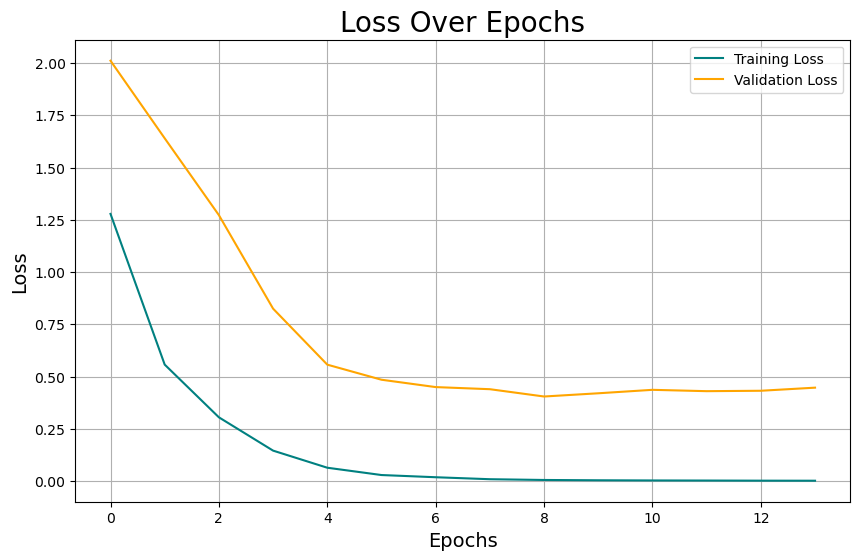

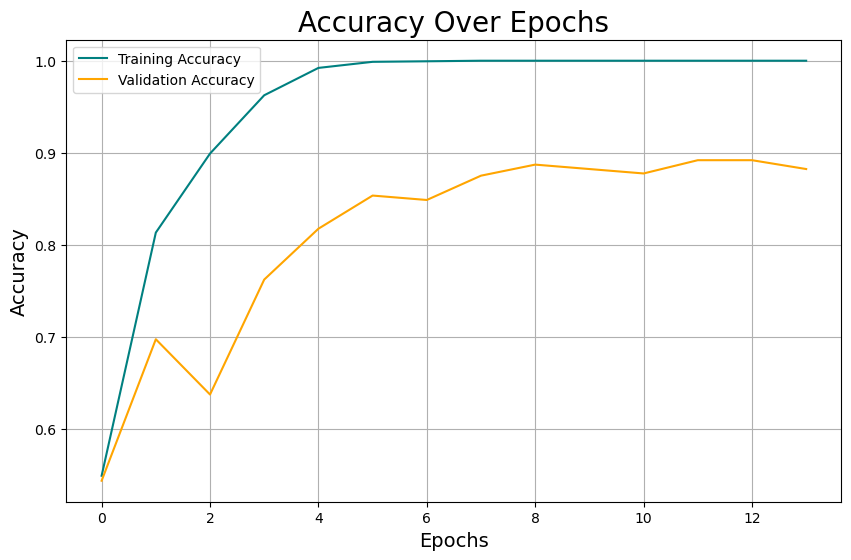

13/13 [==============================] - 2s 160ms/step - loss: 0.2617 - accuracy: 0.9087
Test accuracy: 0.9086538553237915


In [47]:
# Plot performance (loss)
fig = plt.figure(figsize=(10, 6))
plt.plot(history_augmented.history['loss'], color='teal', label='Training Loss')
plt.plot(history_augmented.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Loss Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Plot performance (accuracy)
fig = plt.figure(figsize=(10, 6))
plt.plot(history_augmented.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(history_augmented.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Accuracy Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = augmented_model.evaluate(test_mixed_images_normalized, test_mixed_labels)

print(f"Test accuracy: {test_acc}")

In [48]:
augmented_model.save("augmented_model_normal.keras")
print("Model saved")

Model saved


# Improved Model 
In order to avoid overfitting some dropout layers were added and batches were normalized.

In [49]:
# Improved model architecture with Batch Normalization
augmented_model_upd = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

# Compile the model with a lower initial learning rate
augmented_model_upd.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

augmented_model_upd.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                      

In [50]:
# Train the model 
history_augmented_upd = augmented_model_upd.fit(train_mixed_images_normalized, train_mixed_labels,
                                        epochs=30,  
                                        validation_data=(val_mixed_images_normalized, val_mixed_labels),
                                        callbacks=[early_stopping, reduce_lr])  

Epoch 1/30
104/104 [==============================] - 47s 437ms/step - loss: 1.7528 - accuracy: 0.4255 - val_loss: 5.1953 - val_accuracy: 0.1298 - lr: 1.0000e-04
Epoch 2/30
104/104 [==============================] - 45s 436ms/step - loss: 0.8556 - accuracy: 0.7061 - val_loss: 4.9827 - val_accuracy: 0.1683 - lr: 1.0000e-04
Epoch 3/30
104/104 [==============================] - 42s 400ms/step - loss: 0.5344 - accuracy: 0.8179 - val_loss: 4.1045 - val_accuracy: 0.2284 - lr: 1.0000e-04
Epoch 4/30
104/104 [==============================] - 33s 318ms/step - loss: 0.3507 - accuracy: 0.8792 - val_loss: 2.2395 - val_accuracy: 0.4712 - lr: 1.0000e-04
Epoch 5/30
104/104 [==============================] - 37s 357ms/step - loss: 0.2553 - accuracy: 0.9147 - val_loss: 0.9890 - val_accuracy: 0.6707 - lr: 1.0000e-04
Epoch 6/30
104/104 [==============================] - 45s 429ms/step - loss: 0.1489 - accuracy: 0.9579 - val_loss: 0.6333 - val_accuracy: 0.8053 - lr: 1.0000e-04
Epoch 7/30
104/104 [========

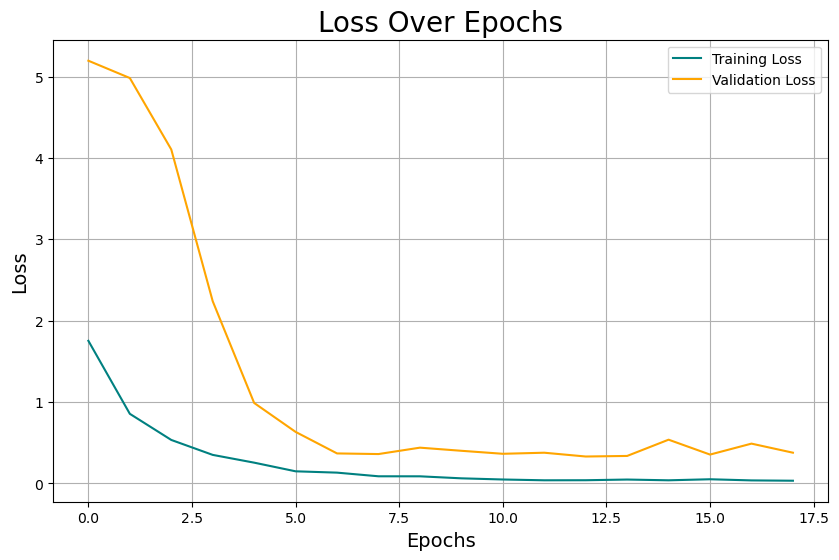

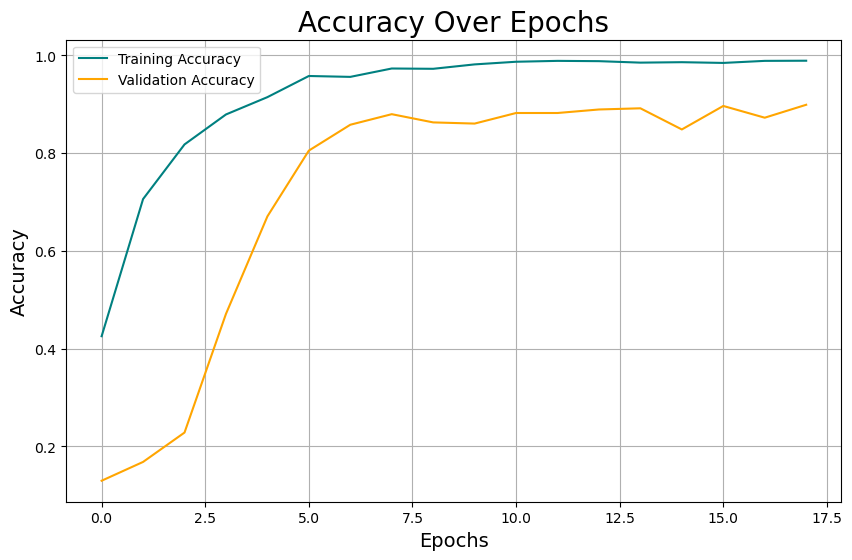

13/13 [==============================] - 1s 87ms/step - loss: 0.2411 - accuracy: 0.9303
Test accuracy: 0.9302884340286255


In [51]:
# Plot performance (loss)
fig = plt.figure(figsize=(10, 6))
plt.plot(history_augmented_upd.history['loss'], color='teal', label='Training Loss')
plt.plot(history_augmented_upd.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Loss Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Plot performance (accuracy)
fig = plt.figure(figsize=(10, 6))
plt.plot(history_augmented_upd.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(history_augmented_upd.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Accuracy Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = augmented_model_upd.evaluate(test_mixed_images_normalized, test_mixed_labels)

# Print the test accuracy
print(f"Test accuracy: {test_acc}")

The final model delivers slighty improved results, however the difference is rather minor. Nevertheless in this case the model does not tend to be overfitted. We assume that for this dataset with that amount of classes it shows a good result. 

In [52]:
#save a model 
augmented_model_upd.save("augmented_model_upd.keras")

In [53]:
#load the model
augmented_model_upd = load_model("augmented_model_best_model.keras")

13/13 [==============================] - 1s 76ms/step


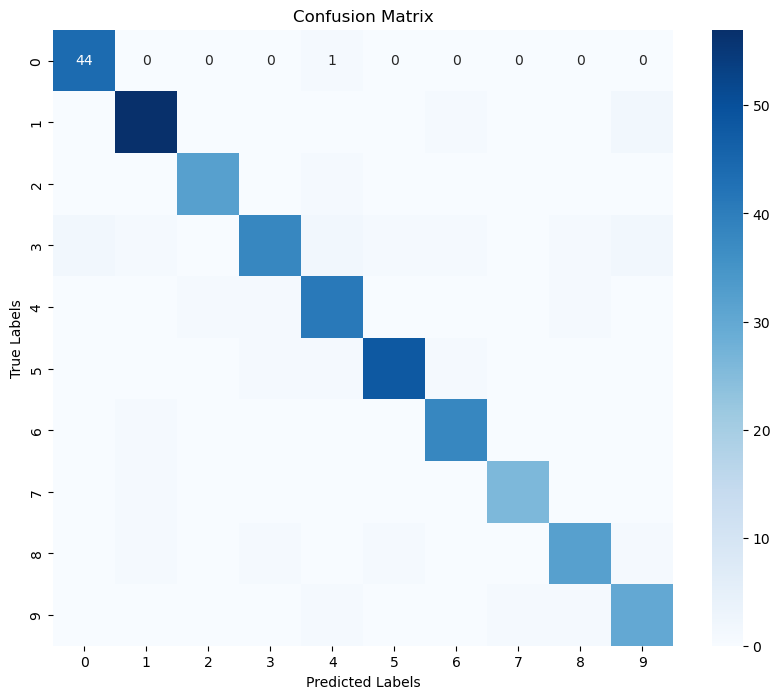

In [54]:
# Generate predictions for the test set
test_predictions = augmented_model_upd.predict(test_mixed_images_normalized)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_mixed_labels, test_pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Prediction results

1/1 [==============================] - 0s 190ms/step


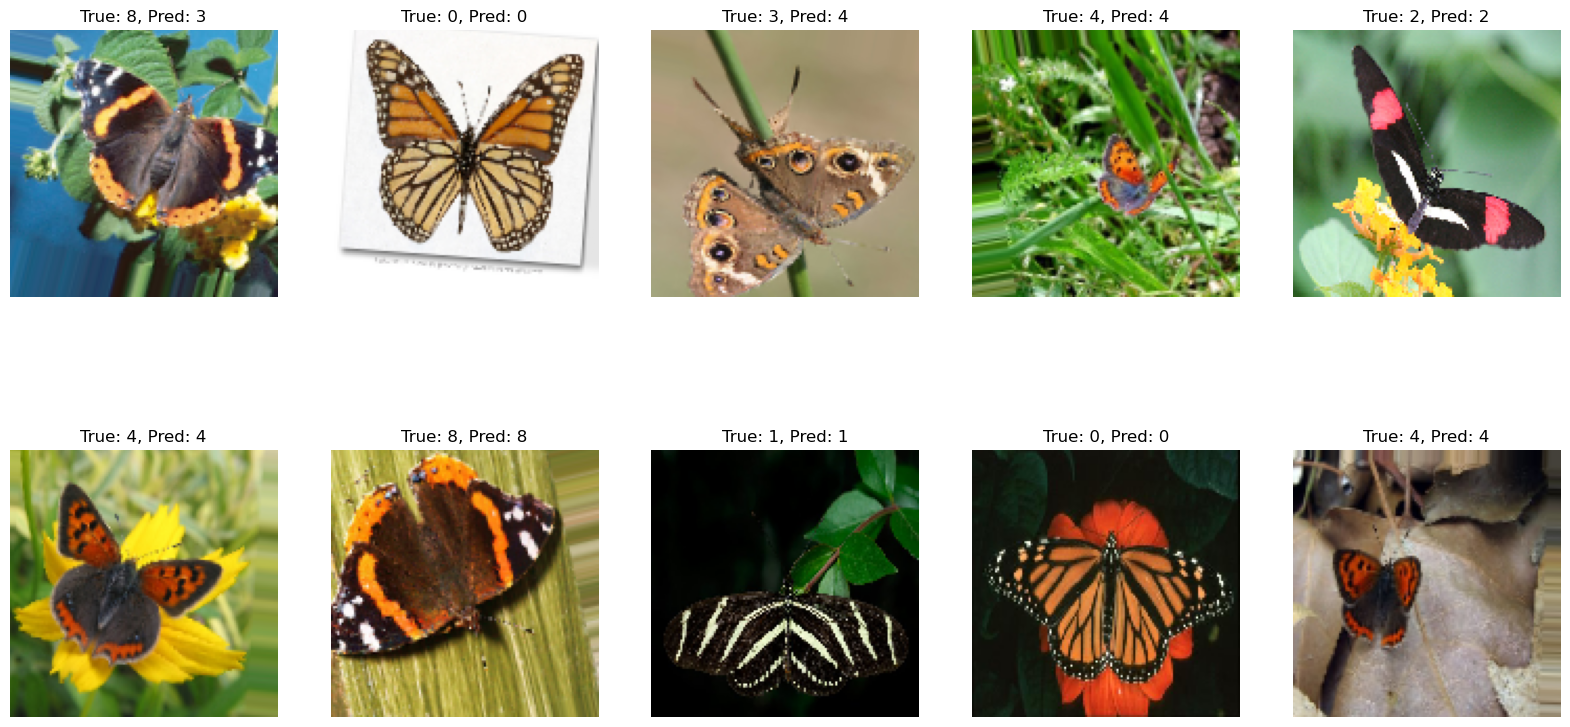

In [55]:
# Select a random subset of images from the test set
num_images_to_plot = 10  # Number of images to plot
random_indices = random.sample(range(len(test_mixed_images_normalized)), num_images_to_plot)
selected_images = test_mixed_images_normalized[random_indices]
selected_true_labels = test_mixed_labels[random_indices]

# Generate predictions for these selected images
selected_predictions = augmented_model_upd.predict(selected_images)
selected_pred_labels = np.argmax(selected_predictions, axis=1)

# Plot the images with their original and predicted labels
plt.figure(figsize=(20, 10))
for i in range(num_images_to_plot):
    plt.subplot(2, 5, i+1)
    plt.imshow(selected_images[i])
    plt.title(f"True: {selected_true_labels[i]}, Pred: {selected_pred_labels[i]}")
    plt.axis('off')
plt.show()


After plotting some random images it is difficult to see which class has worse accuracy scores. We want to see if all classes show consistancy results or not. Further a class with least correct predictions will be found.

13/13 [==============================] - 1s 56ms/step
Class 0: 44 correct predictions out of 45 (97.78%)
Class 1: 57 correct predictions out of 60 (95.00%)
Class 2: 32 correct predictions out of 33 (96.97%)
Class 3: 38 correct predictions out of 48 (79.17%)
Class 4: 41 correct predictions out of 44 (93.18%)
Class 5: 48 correct predictions out of 51 (94.12%)
Class 6: 38 correct predictions out of 39 (97.44%)
Class 7: 26 correct predictions out of 27 (96.30%)
Class 8: 32 correct predictions out of 36 (88.89%)
Class 9: 30 correct predictions out of 33 (90.91%)
Class with the least accuracy: 3 (79.17%)


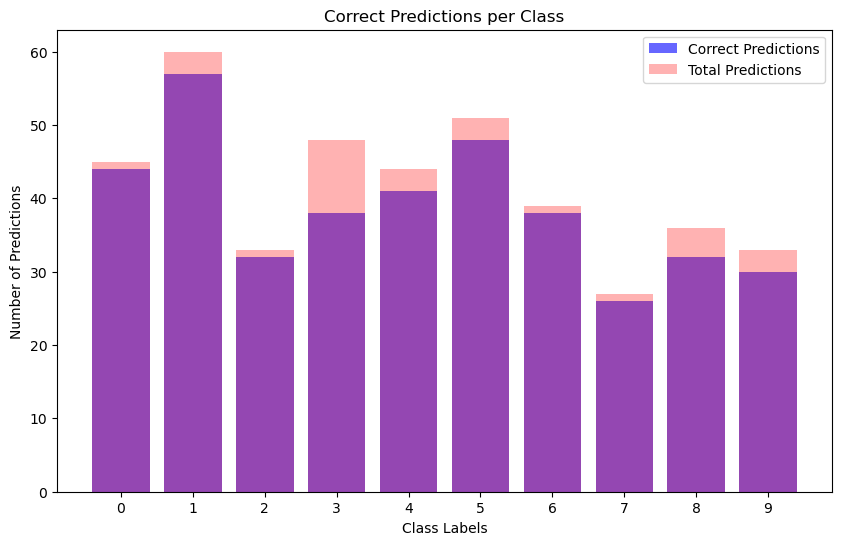

In [58]:
# Generate predictions for the entire test set
test_predictions = augmented_model_upd.predict(test_mixed_images_normalized)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Compare predicted labels with true labels to determine correctness
correct_predictions = (test_pred_labels == test_mixed_labels)

# Count correct predictions and total predictions for each class
correct_counts = Counter()
total_counts = Counter()

# Iterate over true labels and correctness of predictions
for true_label, correct in zip(test_mixed_labels, correct_predictions):
    total_counts[true_label] += 1
    if correct:
        correct_counts[true_label] += 1

# Calculate accuracy for each class
accuracy_per_class = {}
for class_label in range(10): 
    total = total_counts[class_label]
    correct = correct_counts[class_label]
    accuracy = correct / total if total > 0 else 0
    accuracy_per_class[class_label] = accuracy
    print(f"Class {class_label}: {correct} correct predictions out of {total} ({accuracy * 100:.2f}%)")

# Find the class with the least accuracy
least_accurate_class = min(accuracy_per_class, key=accuracy_per_class.get)
print(f"Class with the least accuracy: {least_accurate_class} ({accuracy_per_class[least_accurate_class] * 100:.2f}%)")

# Plot histogram of correct predictions per class
classes = list(range(10))
correct_pred_values = [correct_counts[class_label] for class_label in classes]
total_pred_values = [total_counts[class_label] for class_label in classes]

plt.figure(figsize=(10, 6))
plt.bar(classes, correct_pred_values, color='blue', alpha=0.6, label='Correct Predictions')
plt.bar(classes, total_pred_values, color='red', alpha=0.3, label='Total Predictions')
plt.xlabel('Class Labels')
plt.ylabel('Number of Predictions')
plt.title('Correct Predictions per Class')
plt.legend()
plt.xticks(classes)
plt.show()